In [1]:
# Importing python packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import re

In [2]:
# Importing csvs using Panda
inputHarrisPartI = pd.read_csv("Option 1/HarrisPartI.csv", index_col=False)
inputHarrisPartIII = pd.read_csv("Option 1/HarrisPartIII.csv", index_col=False)
inputKrause21 = pd.read_csv("Option 1/Krause21.csv", index_col=False)
inputVandenBerg = pd.read_csv("Option 1/vandenBerg_table2.csv", index_col=False)

# Importing optional HarrisII from online resource (OPTIONAL)
# inputHarrisPartII = pd.read_csv("Option 1/HarrisPartII.txt", sep='\s+')
inputHarrisPartII = pd.read_csv("Option 1/HarrisPartII.csv", index_col=False)


In [3]:
print("• inputHarrisPartI, entries:", len(inputHarrisPartI))

# First merge (inputHarrisPartI and inputHarrisPartIII)
pre_merged = pd.merge(inputHarrisPartI, inputHarrisPartIII, on="ID")
print("• Merge 1, entries:", len(pre_merged))

# First merge (inputHarrisPartI and inputHarrisPartIII)
pre_merged = pd.merge(pre_merged, inputHarrisPartII, on="ID")
print("• Merge 1, entries:", len(pre_merged))

# -------------------------------------------------------------------
# Modifying Krause21 'Object' field to be consistent with ID from HarrisPartI and HarrisPartIII


def convert_object_to_catid(entry):
    return re.sub("[0-9]+", lambda ele: " " + ele[0], entry)

inputKrause21Converted = inputKrause21.copy()
inputKrause21Converted['Object'] = inputKrause21Converted['Object'].apply(convert_object_to_catid)

# -------------------------------------------------------------------

# Second merge (data_merged and inputKrause21Converted)
pre_merged = pd.merge(pre_merged, inputKrause21Converted, left_on='ID', right_on='Object')
print("• Merge 2, entries:", len(pre_merged))

# -------------------------------------------------------------------
# Modifying vandenBerg '#NGC' field to be consistent with ID from the rest

def convert_ngc_to_catid(entry):
    return "NGC " + entry

inputVandenBergConverted = inputVandenBerg.copy()
inputVandenBergConverted['#NGC'] = inputVandenBergConverted['#NGC'].apply(convert_ngc_to_catid)

# -------------------------------------------------------------------

# Third merge (data_merged and inputVandenBergConverted)
data_merged = pd.merge(pre_merged, inputVandenBergConverted, left_on='ID', right_on='#NGC')
print("• Merge 3, entries:", len(data_merged))

• inputHarrisPartI, entries: 157
• Merge 1, entries: 157
• Merge 1, entries: 157
• Merge 2, entries: 59
• Merge 3, entries: 51


In [4]:
inputVandenBergConverted.rename(columns={'#NGC': 'ID'}, inplace=True)
inputKrause21Converted.rename(columns={'Object': 'ID'}, inplace=True)

data_merged_inclusive = pd.merge(pre_merged, inputVandenBergConverted, on='ID', how='outer', indicator=True)

pd.set_option('display.max_rows', None)

In [5]:
print(data_merged.keys())

# Extrapolating useful keys (at least some of the important ones, for now)
data_kept = data_merged[['ID', 'Age_x', 'Age_y', 'Age_err', 'FeH_x', 'FeH_y', 'r_c', 'mu_V', 'HBtype', 'ellip']]
data_kept_inclusive = data_merged_inclusive[['ID', 'Age_x', 'Age_y', 'Age_err', 'FeH_x', 'FeH_y', 'r_c', 'mu_V', 'HBtype', 'ellip']]
# Renaming some keys for readability
data_kept = data_kept.rename(columns={'Age_x': 'Age_kra', 'Age_y': 'Age_van', 'Age_err': 'Age_err_van', 'FeH_x': 'FeH_kra', 'FeH_y': 'FeH_van'})
data_kept_inclusive = data_kept_inclusive.rename(columns={'Age_x': 'Age_kra', 'Age_y': 'Age_van', 'Age_err': 'Age_err_van', 'FeH_x': 'FeH_kra', 'FeH_y': 'FeH_van'})

print(len(data_kept))
print(len(data_kept_inclusive))

print(data_kept.keys())

Index(['ID', 'Name_x', 'RA', 'DEC', 'L', 'B', 'R_Sun', 'R_gc', 'X', 'Y', 'Z',
       'v_r', 'v_r_e', 'v_LSR', 'sig_v', 'sig_v_e', 'c', 'r_c', 'r_h', 'mu_V',
       'rho_0', 'lg_tc', 'lg_th', '[Fe/', 'H] wt', 'E(B', '-V) V_', 'HB (m-',
       'M)V V_t', 'M_V,t', 'U-B', 'B-V', 'V-R', 'V-I', 'spt', 'ellip', 'Class',
       'Object', 'AltName', 'Mstar', 'rh', 'C5', 'Age_x', 'FeH_x', '#NGC',
       'Name_y', 'FeH_y', 'Age_y', 'Age_err', 'Method', 'Figs', 'Range',
       'HBtype', 'R_G', 'M_V', 'v_e0', 'log_sigma_0'],
      dtype='object')
51
63
Index(['ID', 'Age_kra', 'Age_van', 'Age_err_van', 'FeH_kra', 'FeH_van', 'r_c',
       'mu_V', 'HBtype', 'ellip'],
      dtype='object')


## Age vs [Fe/H]

In [6]:
# Color graph function definition
def plot_color_graph(x: any, y: any, color: any, label_color: str, title: str, xlabel: str, ylabel: str):
    plt.scatter(
        x,
        y,
        c=color,
        zorder=2,
    )
    cbar = plt.colorbar()
    cbar.set_label(label_color)
    plt.grid(zorder=1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

## Discrepancy between Krause and VandenBerg Values

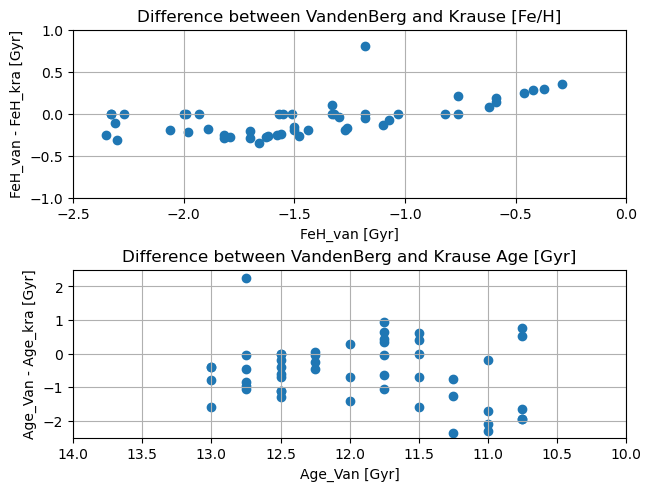

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, layout="constrained")

ax1.scatter(
    data_kept['FeH_van'],
    data_kept['FeH_van'] - data_kept['FeH_kra']
)
ax1.grid(True)
ax1.xaxis.set_inverted(True)
ax1.set_title('Difference between VandenBerg and Krause [Fe/H]')
ax1.set_xlabel('FeH_van [Gyr]')
ax1.set_xlim(-2.5, 0)
ax1.set_ylim(-1, 1)
ax1.set_ylabel('FeH_van - FeH_kra [Gyr]')

ax2.scatter(
    data_kept['Age_van'],
    data_kept['Age_van'] - data_kept['Age_kra']
)
ax2.grid(True)
ax2.xaxis.set_inverted(True)
ax2.set_title('Difference between VandenBerg and Krause Age [Gyr]')
ax2.set_xlabel('Age_Van [Gyr]')
ax2.set_xlim(14, 10)
ax2.set_ylim(-2.5, 2.5)
ax2.set_ylabel('Age_Van - Age_kra [Gyr]')


plt.show()

<img src="resources/krause vs vandenberg.png" width="600"/>

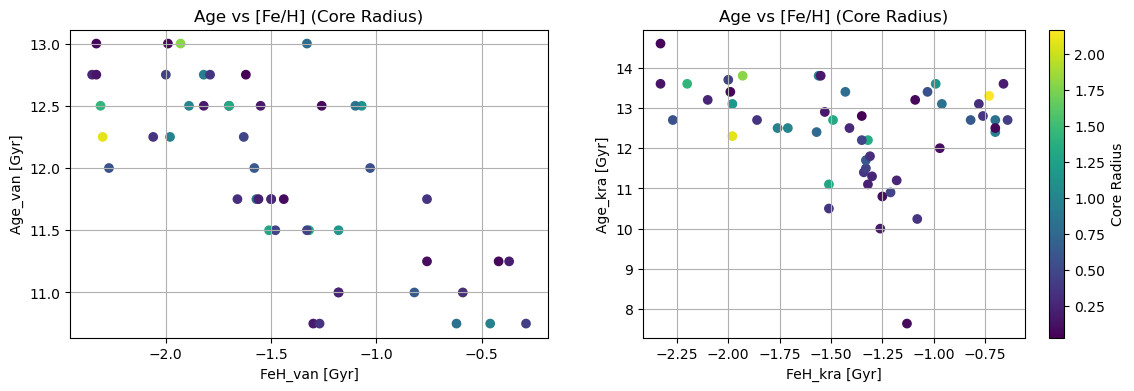

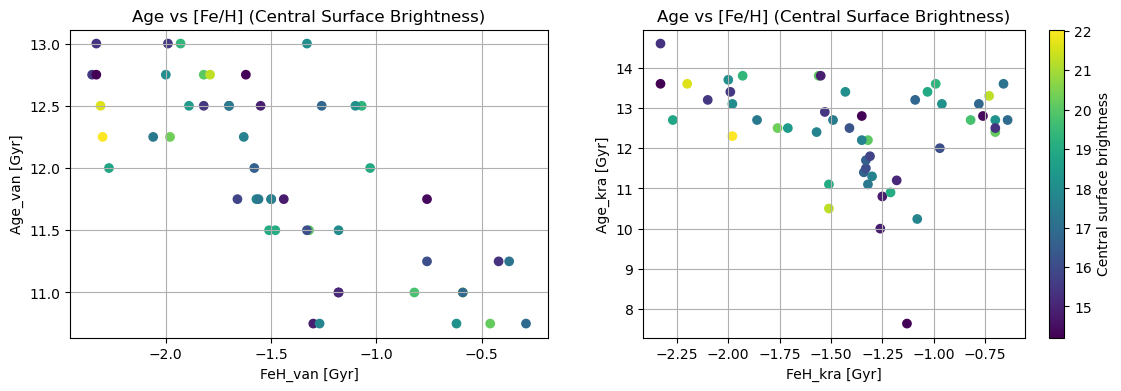

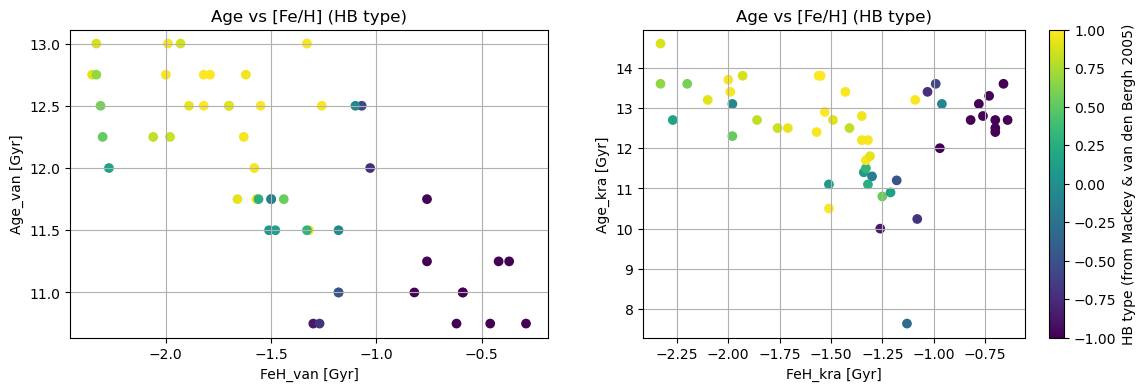

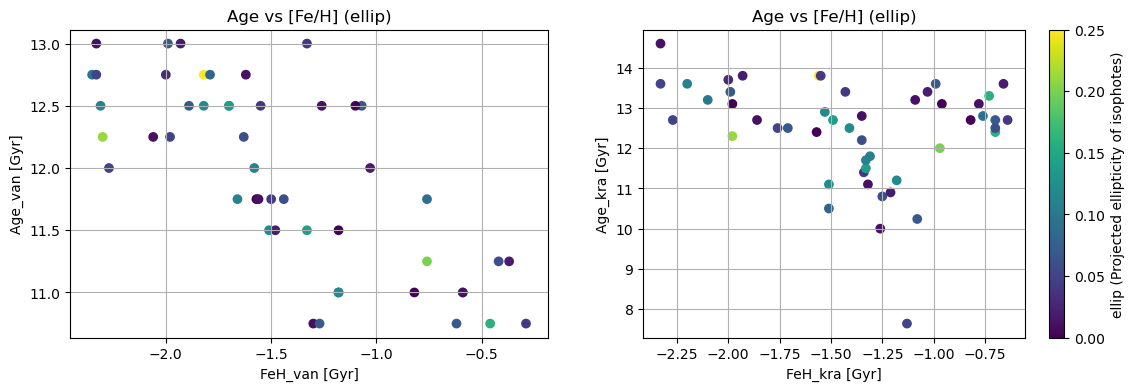

In [8]:
# Core Radius

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

im = ax1.scatter(data_kept['FeH_van'], data_kept['Age_van'], c=data_kept['r_c'])
ax1.grid(True)
ax1.set_title('Age vs [Fe/H] (Core Radius)')
ax1.set_xlabel('FeH_van [Gyr]')
ax1.set_ylabel('Age_van [Gyr]')

im = ax2.scatter(data_kept['FeH_kra'], data_kept['Age_kra'], c=data_kept['r_c'])
ax2.grid(True)
ax2.set_title('Age vs [Fe/H] (Core Radius)')
ax2.set_xlabel('FeH_kra [Gyr]')
ax2.set_ylabel('Age_kra [Gyr]')

fig.subplots_adjust(right=1)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label("Core Radius")

plt.show()

# -------------------------------------------
# Central surface brightness (V magnitudes per square arcsecond)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

im = ax1.scatter(data_kept['FeH_van'], data_kept['Age_van'], c=data_kept['mu_V'])
ax1.grid(True)
ax1.set_title('Age vs [Fe/H] (Central Surface Brightness)')
ax1.set_xlabel('FeH_van [Gyr]')
ax1.set_ylabel('Age_van [Gyr]')

im = ax2.scatter(data_kept['FeH_kra'], data_kept['Age_kra'], c=data_kept['mu_V'])
ax2.grid(True)
ax2.set_title('Age vs [Fe/H] (Central Surface Brightness)')
ax2.set_xlabel('FeH_kra [Gyr]')
ax2.set_ylabel('Age_kra [Gyr]')

fig.subplots_adjust(right=1)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label("Central surface brightness")

plt.show()

# -------------------------------------------
# HB type (from Mackey & van den Bergh 2005)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

im = ax1.scatter(data_kept['FeH_van'], data_kept['Age_van'], c=data_kept['HBtype'])
ax1.grid(True)
ax1.set_title('Age vs [Fe/H] (HB type)')
ax1.set_xlabel('FeH_van [Gyr]')
ax1.set_ylabel('Age_van [Gyr]')

im = ax2.scatter(data_kept['FeH_kra'], data_kept['Age_kra'], c=data_kept['HBtype'])
ax2.grid(True)
ax2.set_title('Age vs [Fe/H] (HB type)')
ax2.set_xlabel('FeH_kra [Gyr]')
ax2.set_ylabel('Age_kra [Gyr]')

fig.subplots_adjust(right=1)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label("HB type (from Mackey & van den Bergh 2005)")

plt.show()

# -------------------------------------------
# ellip, Projected ellipticity of isophotes, e = 1-(b/a)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))

im = ax1.scatter(data_kept['FeH_van'], data_kept['Age_van'], c=data_kept['ellip'])
ax1.grid(True)
ax1.set_title('Age vs [Fe/H] (ellip)')
ax1.set_xlabel('FeH_van [Gyr]')
ax1.set_ylabel('Age_van [Gyr]')

im = ax2.scatter(data_kept['FeH_kra'], data_kept['Age_kra'], c=data_kept['ellip'])
ax2.grid(True)
ax2.set_title('Age vs [Fe/H] (ellip)')
ax2.set_xlabel('FeH_kra [Gyr]')
ax2.set_ylabel('Age_kra [Gyr]')

fig.subplots_adjust(right=1)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label("ellip (Projected ellipticity of isophotes)")

plt.show()

In [9]:
import plotly.graph_objs as go
import plotly.offline as pyo

pyo.init_notebook_mode(connected=True)

# Variables you want to be switchable
color_vars = {
    'Age_kra [Gyr]': data_kept['Age_kra'],
    '[FeH]': data_kept['FeH_kra'],
    'Core Radius': data_kept['r_c'],
    'Central surface brightness (V magnitudes per square arcsecond)': data_kept['mu_V'],
    'HB type (from Mackey & van den Bergh 2005)': data_kept['HBtype'],
    'ellip (Projected ellipticity of isophotes)': data_kept['ellip'],
}

# Create one trace per color_var (only one visible at a time)
traces = []
for i, (label, values) in enumerate(color_vars.items()):
    trace = go.Scatter3d(
        x=data_merged['X'],
        y=data_merged['Y'],
        z=data_merged['Z'],
        mode='markers',
        marker=dict(
            size=5,
            color=values,
            colorscale='Viridis',
            opacity=0.8,
            colorbar=dict(title=label)  # Only show one colorbar at a time
        ),
        name=label,
        visible=(i == 0)  # Only the first one starts visible
    )
    traces.append(trace)

# ----------------------- Plot rough Milky Way shape ------------------------

# ------------- Disc Mesh -----------------------

# Disc parameters
center = np.array([8, 0, 0])
radius = np.array([0, 5, 10, 15, 20, 20, 25])
num_points = 100

# Generate circular mesh
theta = np.linspace(0, 2*np.pi, num_points)
x = center[0] + radius[6] * np.cos(theta)
y = center[1] + radius[6] * np.sin(theta)
z = np.zeros_like(x) + center[2]  # plane z=0

# Add a central point (for filling the disc)
x_mesh = np.append(x, center[0])
y_mesh = np.append(y, center[1])
z_mesh = np.append(z, center[2])

# Create triangles connecting each ring segment to the center
i = list(range(num_points))
j = [(k + 1) % num_points for k in range(num_points)]
k = [num_points] * num_points  # the center index

disc = go.Mesh3d(
    x=x_mesh,
    y=y_mesh,
    z=z_mesh,
    i=i, j=j, k=k,
    color='lightblue',
    opacity=0.2,
    name='Galactic plane',
    showscale=False
)

# ------------------ Disc Outline ------------------------------
disc_edges = []
for radii in radius:
    # Circular outline (edge only)
    theta = np.linspace(0, 2*np.pi, 200)
    x_edge = center[0] + radii * np.cos(theta)
    y_edge = center[1] + radii * np.sin(theta)
    z_edge = np.zeros_like(x_edge) + center[2]  # Flat z-plane

    disc_edge = go.Scatter3d(
        x=x_edge,
        y=y_edge,
        z=z_edge,
        mode='lines',
        line=dict(color='lightblue', width=3),
        name='Galactic Plane Edge',
        visible=True
    )
    disc_edges.append(disc_edge)


# ---------------------- Buttons and Layout ---------------------------------
# Create buttons to switch between variables
buttons = []

for i, (label, _) in enumerate(color_vars.items()):
    # Create a list of visibilities (traces + disc + disc_edges)
    visibility = [False] * len(traces) + [True] * (1 + len(disc_edges))
    visibility[i] = True # Make the selected trace visible

    buttons.append(dict(
        label=label,
        method='update',
        args=[
            {'visible': visibility},
            {'title': f'3D Scatter colored by {label}'}
        ]
    ))

# Layout with dropdown
layout = go.Layout(
    title='3D Scatter colored by Age (ka)',
    margin={'l': 0, 'r': 0, 'b': 0, 't': 30},
    updatemenus=[{
        'buttons': buttons,
        'direction': 'down',
        'showactive': True,
        'x': 1.2,
        'xanchor': 'left',
        'y': 1.05,
        'yanchor': 'top'
    }],
    scene=dict(
        aspectmode='data'
    )
)

# Add all of the above to the figure (i.e. traces and MW disc)
fig = go.Figure(data=traces + [disc] + disc_edges, layout=layout)
fig.update_layout(
    showlegend=False,
    scene_camera=dict(
        eye=dict(x=0.2, y=0.2, z=0.2)
    )
)
pyo.iplot(fig)